## 1. Environment Setup

In [1]:
!pip install transformers datasets evaluate rouge_score bert_score accelerate sentence-transformers scikit-learn -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.0 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading
Load the dataset containing video transcripts and their corresponding summaries (or chapters).

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory to a clean output location
GDRIVE_ROOT =  "/content/drive/MyDrive/CS_685/youtube-video-summarization/"

%cd $GDRIVE_ROOT

Mounted at /content/drive
/content/drive/MyDrive/CS_685/youtube-video-summarization


In [4]:
DATASET_REPO = "lucas-ventura/chapter-llama"

def load_json_from_hf(path_in_repo: str) -> dict:
    """Download a JSON file from the HF dataset repo and load it."""
    print(f"Downloading {path_in_repo}...")
    local_path = hf_hub_download(repo_id=DATASET_REPO, filename=path_in_repo, repo_type="dataset")
    with open(local_path, "r", encoding="utf-8") as f:
        return json.load(f)

def seconds_to_hhmmss(t: float) -> str:
    """Convert seconds to HH:MM:SS (floor)."""
    t = max(0, int(t))
    h = t // 3600
    m = (t % 3600) // 60
    s = t % 60
    return f"{h:02d}:{m:02d}:{s:02d}"

def normalize_transcript(asr_data):
    """Convert ASR data to a list of dicts: [{'start': float, 'end': float, 'text': str}, ...]"""
    segments = []
    if isinstance(asr_data, dict):
        # dict of lists: {'text': [], 'start': [], 'end': []}
        texts = asr_data.get("text", [])
        starts = asr_data.get("start", [])
        ends = asr_data.get("end", [])
        for t, s, e in zip(texts, starts, ends):
            segments.append({"start": float(s), "end": float(e), "text": t})
    elif isinstance(asr_data, list):
        # list of dicts
        for seg in asr_data:
            segments.append({
                "start": float(seg.get("start", 0)),
                "end": float(seg.get("end", 0)),
                "text": seg.get("text", "")
            })

    # Sort by start time
    segments.sort(key=lambda x: x["start"])
    return segments

def normalize_chapters(chapters_dict, duration):
    """Convert chapters dict {'start_time': 'title'} to list of dicts [{'start': float, 'end': float, 'title': str}]"""
    # Sort by start time
    sorted_chaps = []
    for start_str, title in chapters_dict.items():
        try:
            start = float(start_str)
            sorted_chaps.append((start, title))
        except ValueError:
            continue
    sorted_chaps.sort(key=lambda x: x[0])

    final_chapters = []
    for i, (start, title) in enumerate(sorted_chaps):
        # End time is start of next chapter, or video duration for the last one
        if i < len(sorted_chaps) - 1:
            end = sorted_chaps[i+1][0]
        else:
            end = float(duration) if duration else start + 600 # Fallback if duration missing

        final_chapters.append({
            "start": start,
            "end": end,
            "title": title,
            "start_hhmmss": seconds_to_hhmmss(start),
            "end_hhmmss": seconds_to_hhmmss(end)
        })
    return final_chapters

# Load data
print("Loading JSONs from Hugging Face...")
chapters_train = load_json_from_hf("docs/subset_data/chapters/chapters_sml1k_train.json")
asrs_train = load_json_from_hf("docs/subset_data/asrs/asrs_sml1k_train.json")

# Find intersection of video IDs
video_ids = list(set(chapters_train.keys()) & set(asrs_train.keys()))
print(f"Found {len(video_ids)} videos with both chapters and ASR data.")

Loading JSONs from Hugging Face...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


chapters_sml1k_train.json: 0.00B [00:00, ?B/s]

docs/subset_data/asrs/asrs_sml1k_train.j(…):   0%|          | 0.00/28.0M [00:00<?, ?B/s]

Found 972 videos with both chapters and ASR data.


## 2.5 Segment Number Prediction

To improve alignment accuracy, we train a regressor to predict the optimal number of segments (chapters) for a video based on its duration and transcript length. This predicted number ($K$) will then be used to force the segmentation algorithms to produce exactly $K$ segments.


In [5]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score
import joblib

# 1. Feature Extraction
def extract_features(chapters_data, asrs_data, video_ids):
    X = []
    y = []

    for vid in video_ids:
        chap_entry = chapters_data.get(vid, {})
        asr_entry = asrs_data.get(vid, [])

        duration = chap_entry.get("duration", 0)
        if duration <= 0: continue # Skip invalid

        # Normalize transcript
        transcript_segments = normalize_transcript(asr_entry)
        if not transcript_segments: continue

        # Features
        transcript_text = " ".join([seg['text'] for seg in transcript_segments])
        num_words = len(transcript_text.split())
        num_asr_segments = len(transcript_segments)
        words_per_second = num_words / duration if duration > 0 else 0

        # Target: Number of Chapters
        num_chapters = len(chap_entry.get("chapters", {}))

        if num_chapters > 0:
            X.append([duration, num_words, num_asr_segments, words_per_second])
            y.append(num_chapters)

    return np.array(X), np.array(y)

print("Extracting features for Segment Number Prediction...")
X, y = extract_features(chapters_train, asrs_train, video_ids)
print(f"Extracted {len(X)} samples.")

# 2. Train Regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Switch to GradientBoostingRegressor for potentially better performance
seg_num_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
seg_num_model.fit(X_train, y_train)

# Evaluate
preds = seg_num_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"Segment Number Prediction MAE: {mae:.2f} chapters")

# Calculate Classification Metrics (Exact Match)
preds_rounded = np.round(preds).astype(int)
accuracy = accuracy_score(y_test, preds_rounded)
recall = recall_score(y_test, preds_rounded, average='weighted', zero_division=0)

print(f"Segment Number Prediction Accuracy (Exact Match): {accuracy:.2%}")
print(f"Segment Number Prediction Recall (Weighted): {recall:.2%}")

# Feature Importance
feature_names = ["Duration", "Num Words", "Num Segments", "Words/Sec"]
importances = seg_num_model.feature_importances_
for name, imp in zip(feature_names, importances):
    print(f"Feature {name}: {imp:.4f}")

# 3. Save Model
joblib.dump(seg_num_model, "models/segment_num_predictor.joblib")
print("Segment Number Predictor saved to models/segment_num_predictor.joblib")

# 4. Prediction Function
def predict_num_segments(duration, transcript_segments, model):
    """
    Predicts K based on duration and transcript segments list.
    """
    transcript_text = " ".join([s['text'] for s in transcript_segments])
    num_words = len(transcript_text.split())
    num_asr_segments = len(transcript_segments)
    words_per_second = num_words / duration if duration > 0 else 0

    features = np.array([[duration, num_words, num_asr_segments, words_per_second]])
    pred = model.predict(features)[0]
    return max(1, int(round(pred))) # Ensure at least 1 segment

# Test
test_vid = video_ids[0]
test_dur = chapters_train[test_vid]['duration']
test_segments = normalize_transcript(asrs_train[test_vid])
pred_k = predict_num_segments(test_dur, test_segments, seg_num_model)
print(f"Predicted segments for video {test_vid}: {pred_k} (True: {len(chapters_train[test_vid]['chapters'])})")

Extracting features for Segment Number Prediction...
Extracted 972 samples.
Segment Number Prediction MAE: 4.39 chapters
Segment Number Prediction Accuracy (Exact Match): 8.21%
Segment Number Prediction Recall (Weighted): 8.21%
Feature Duration: 0.2934
Feature Num Words: 0.2546
Feature Num Segments: 0.2491
Feature Words/Sec: 0.2028
Segment Number Predictor saved to models/segment_num_predictor.joblib
Predicted segments for video N7gJsCrS31k: 7 (True: 8)


## 3. Segmentation Strategy 1: Fixed-Length Windowing (Adaptive K)

This method splits the transcript into $K$ chunks of equal duration, where $K$ is predicted by our regressor.

In [6]:
def segment_transcript_fixed_k(asr_segments, k):
    """
    Segments the transcript into K chunks of equal duration.
    """
    if not asr_segments or k <= 0:
        return []

    asr_segments.sort(key=lambda x: x['start'])

    start_time = asr_segments[0]['start']
    end_time = asr_segments[-1]['end']
    total_duration = end_time - start_time

    # Calculate target duration per segment
    segment_duration = total_duration / k

    windows = []
    current_window_text = []
    current_window_start = start_time
    current_target_end = start_time + segment_duration

    for seg in asr_segments:
        # If segment starts after the target end, close the window
        if seg['start'] >= current_target_end and len(windows) < k - 1:
            # Save current window
            windows.append({
                'start': current_window_start,
                'end': seg['start'], # Use actual start of next segment as boundary
                'text': " ".join(current_window_text) if current_window_text else ""
            })

            # Start new window
            current_window_text = [seg['text']]
            current_window_start = seg['start']
            current_target_end += segment_duration
        else:
            current_window_text.append(seg['text'])

    # Add the last window
    windows.append({
        'start': current_window_start,
        'end': end_time,
        'text': " ".join(current_window_text) if current_window_text else ""
    })

    return windows

# Test on one video
example_vid = video_ids[0]
asr_data = normalize_transcript(asrs_train[example_vid])
pred_k = predict_num_segments(chapters_train[example_vid]['duration'], asr_data, seg_num_model)

print(f"Video ID: {example_vid}")
print(f"Predicted K: {pred_k}")

fixed_windows = segment_transcript_fixed_k(asr_data, k=pred_k)
print(f"Fixed-length windows: {len(fixed_windows)}")

for i, win in enumerate(fixed_windows[:3]):
    print(f"Window {i}: {win['start']:.1f}s - {win['end']:.1f}s | Text len: {len(win['text'])}")

Video ID: N7gJsCrS31k
Predicted K: 7
Fixed-length windows: 7
Window 0: 1.8s - 60.7s | Text len: 138
Window 1: 60.7s - 70.9s | Text len: 133
Window 2: 70.9s - 97.1s | Text len: 109


## 4. Segmentation Strategy 2: Semantic Segmentation (Adaptive K)

This method uses Sentence-BERT embeddings and finds the top $K-1$ boundaries with the lowest semantic similarity to split the transcript into exactly $K$ segments.

In [7]:
def segment_transcript_semantic_k(asr_segments, k, model):
    """
    Segments transcript into K chunks using semantic similarity.
    Finds the K-1 boundaries with the lowest cosine similarity.
    """
    if not asr_segments:
        return []
    if k <= 1:
        return [{
            'start': asr_segments[0]['start'],
            'end': asr_segments[-1]['end'],
            'text': " ".join([s['text'] for s in asr_segments])
        }]

    asr_segments.sort(key=lambda x: x['start'])

    # 1. Get embeddings
    texts = [seg['text'] for seg in asr_segments]
    embeddings = model.encode(texts, show_progress_bar=False)

    # 2. Calculate similarity between consecutive segments
    similarities = []
    for i in range(len(embeddings) - 1):
        sim = cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0]
        similarities.append((sim, i)) # Store (similarity, index)

    # 3. Find top K-1 split points (lowest similarity)
    # Sort by similarity ascending
    similarities.sort(key=lambda x: x[0])

    # Get indices of the lowest K-1 similarities
    split_indices = [x[1] for x in similarities[:k-1]]
    split_indices.sort() # Sort indices to process in order

    # 4. Create windows
    windows = []
    current_start_idx = 0

    for split_idx in split_indices:
        # Segment from current_start_idx to split_idx (inclusive)
        segment_asr = asr_segments[current_start_idx : split_idx+1]

        windows.append({
            'start': segment_asr[0]['start'],
            'end': asr_segments[split_idx+1]['start'], # End at start of next
            'text': " ".join([s['text'] for s in segment_asr])
        })

        current_start_idx = split_idx + 1

    # Add last window
    segment_asr = asr_segments[current_start_idx:]
    if segment_asr:
        windows.append({
            'start': segment_asr[0]['start'],
            'end': segment_asr[-1]['end'],
            'text': " ".join([s['text'] for s in segment_asr])
        })

    return windows

def segment_transcript_semantic_threshold(asr_segments, model, threshold=0.5):
    """
    Segments transcript using semantic similarity threshold.
    Splits where cosine similarity < threshold.
    """
    if not asr_segments:
        return []

    asr_segments.sort(key=lambda x: x['start'])

    # 1. Get embeddings
    texts = [seg['text'] for seg in asr_segments]
    embeddings = model.encode(texts, show_progress_bar=False)

    # 2. Calculate similarity between consecutive segments
    split_indices = []
    for i in range(len(embeddings) - 1):
        sim = cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0]
        if sim < threshold:
            split_indices.append(i)

    # 3. Create windows
    windows = []
    current_start_idx = 0

    for split_idx in split_indices:
        segment_asr = asr_segments[current_start_idx : split_idx+1]
        windows.append({
            'start': segment_asr[0]['start'],
            'end': asr_segments[split_idx+1]['start'],
            'text': " ".join([s['text'] for s in segment_asr])
        })
        current_start_idx = split_idx + 1

    # Add last window
    segment_asr = asr_segments[current_start_idx:]
    if segment_asr:
        windows.append({
            'start': segment_asr[0]['start'],
            'end': segment_asr[-1]['end'],
            'text': " ".join([s['text'] for s in segment_asr])
        })

    return windows

# Load Sentence-BERT
print("Loading Sentence-BERT...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

# Test on one video
print(f"\nTesting Semantic Segmentation (K={pred_k}) on {example_vid}...")
semantic_windows = segment_transcript_semantic_k(asr_data, k=pred_k, model=sbert_model)
print(f"Semantic windows (Adaptive K): {len(semantic_windows)}")

# Test Threshold
semantic_windows_thresh = segment_transcript_semantic_threshold(asr_data, model=sbert_model, threshold=0.4)
print(f"Semantic windows (Threshold=0.4): {len(semantic_windows_thresh)}")

for i, win in enumerate(semantic_windows[:3]):
    print(f"Window {i}: {win['start']:.1f}s - {win['end']:.1f}s | Text: {win['text'][:100]}...")

Loading Sentence-BERT...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Testing Semantic Segmentation (K=7) on N7gJsCrS31k...
Semantic windows (Adaptive K): 7
Semantic windows (Threshold=0.4): 12
Window 0: 1.8s - 6.5s | Text:  I'm waiting for the announcement, do take your helmet off....
Window 1: 6.5s - 99.7s | Text: Some of them do. Yeah, they don't like it in case you're here to steal petrol.  This is the bit wher...
Window 2: 99.7s - 105.8s | Text: I don't know if the camera will pick that up or not....


## 5. Visualization & Comparison

Let's visualize the segmentation boundaries against the ground truth chapters.

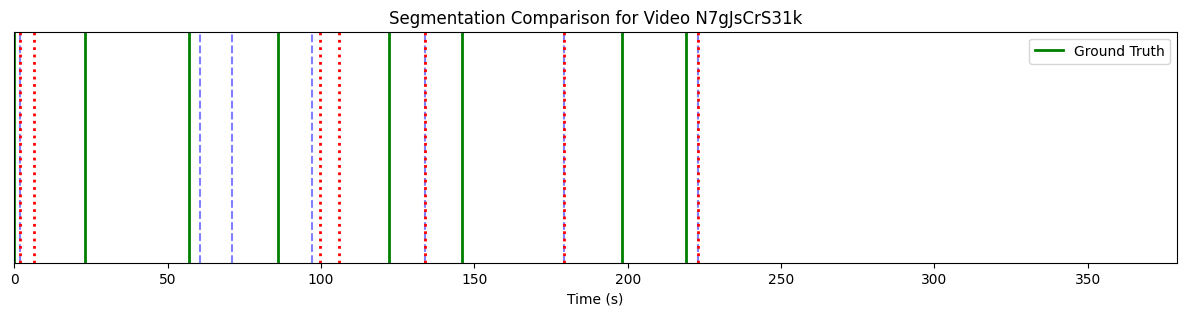

In [8]:
def plot_segmentation(video_id, fixed_windows, semantic_windows, gt_chapters):
    duration = gt_chapters[-1]['end']

    fig, ax = plt.subplots(figsize=(15, 3))

    # Plot Ground Truth
    for chap in gt_chapters:
        ax.axvline(x=chap['start'], color='green', linestyle='-', linewidth=2, label='Ground Truth' if chap['start']==0 else "")

    # Plot Fixed Windows
    for win in fixed_windows:
        ax.axvline(x=win['start'], color='blue', linestyle='--', alpha=0.5, label='Fixed Window' if win['start']==0 else "")

    # Plot Semantic Windows
    for win in semantic_windows:
        ax.axvline(x=win['start'], color='red', linestyle=':', linewidth=2, label='Semantic' if win['start']==0 else "")

    ax.set_xlim(0, duration)
    ax.set_yticks([])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Segmentation Comparison for Video {video_id}")
    ax.legend(loc='upper right')
    plt.show()

# Get Ground Truth
gt_chapters = normalize_chapters(chapters_train[example_vid]['chapters'], chapters_train[example_vid]['duration'])

plot_segmentation(example_vid, fixed_windows, semantic_windows, gt_chapters)

## 6. Dataset Creation for Evaluation

Now we create datasets using these segmentation methods to evaluate the downstream tasks (Summarization & Alignment).

In [ ]:
def build_segmented_dataset_for_eval(chapters_train, asrs_train, video_ids, method='fixed', k_mode='predicted', constant_k=6, threshold=0.5, **kwargs):
    data_list = []
    
    print(f"Building dataset using '{method}' segmentation (K mode: {k_mode})...")
    
    for vid in video_ids:
        chap_entry = chapters_train.get(vid, {})
        asr_entry = asrs_train.get(vid, [])
        
        duration = chap_entry.get("duration", 0)
        chapters_normalized = normalize_chapters(chap_entry.get("chapters", {}), duration)
        transcript_normalized = normalize_transcript(asr_entry)
        
        # Determine K (if needed)
        if k_mode == 'predicted':
            # Updated call to predict_num_segments
            k = predict_num_segments(duration, transcript_normalized, seg_num_model)
        else:
            k = constant_k
        
        if method == 'fixed':
            segments = segment_transcript_fixed_k(transcript_normalized, k=k)
        elif method == 'semantic':
            segments = segment_transcript_semantic_k(transcript_normalized, k=k, model=kwargs.get('model'))
        elif method == 'semantic_threshold':
            segments = segment_transcript_semantic_threshold(transcript_normalized, model=kwargs.get('model'), threshold=threshold)
        else:
            segments = []
            
        for seg in segments:
            # Find closest ground truth chapter (for reference/labeling)
            best_overlap = 0
            best_title = None
            
            for chap in chapters_normalized:
                start = max(seg['start'], chap['start'])
                end = min(seg['end'], chap['end'])
                overlap = max(0, end - start)
                
                if overlap > best_overlap:
                    best_overlap = overlap
                    best_title = chap['title']
            
            data_list.append({
                "video_id": vid,
                "start": seg['start'],
                "end": seg['end'],
                "text": seg['text'],
                "title": best_title if best_title else "", 
                "chapters": chapters_normalized
            })
            
    return Dataset.from_list(data_list)

# Create datasets
# Split dataset into Train (90%) and Test (10%)
import random
random.seed(42)
shuffled_ids = video_ids.copy()
random.shuffle(shuffled_ids)

split_idx = int(len(shuffled_ids) * 0.9)
train_vids_split = shuffled_ids[:split_idx]
test_vids_split = shuffled_ids[split_idx:]

print(f"Total Videos: {len(video_ids)}")
print(f"Training Set: {len(train_vids_split)}")
print(f"Test Set: {len(test_vids_split)}")

# Use Test Set for Evaluation
subset_vids = test_vids_split
print(f"Using {len(subset_vids)} videos for testing.")

# 1. Fixed Window (Constant K=6) - "Fixed K for fixed windows method"
ds_fixed_constant = build_segmented_dataset_for_eval(chapters_train, asrs_train, subset_vids, method='fixed', k_mode='constant', constant_k=6)

# 2. Semantic (Adaptive K) - "Let semantic method determine by itself" (Option A: Predicted K)
ds_semantic_adaptive = build_segmented_dataset_for_eval(chapters_train, asrs_train, subset_vids, method='semantic', k_mode='predicted', model=sbert_model)

# 3. Semantic (Threshold) - "Let semantic method determine by itself" (Option B: Threshold)
ds_semantic_threshold = build_segmented_dataset_for_eval(chapters_train, asrs_train, subset_vids, method='semantic_threshold', threshold=0.4, model=sbert_model)

print(f"Fixed (Constant K=6) Dataset Size: {len(ds_fixed_constant)}")
print(f"Semantic (Adaptive K) Dataset Size: {len(ds_semantic_adaptive)}")
print(f"Semantic (Threshold=0.4) Dataset Size: {len(ds_semantic_threshold)}")

Using subset of 10 videos for testing.
Building dataset using 'fixed' segmentation (K mode: constant)...
Building dataset using 'semantic' segmentation (K mode: predicted)...
Building dataset using 'semantic_threshold' segmentation (K mode: predicted)...
Fixed (Constant K=6) Dataset Size: 60
Semantic (Adaptive K) Dataset Size: 78
Semantic (Threshold=0.4) Dataset Size: 1161


## 6.5 Train Alignment Model (Missing from Pipeline)

Since the alignment model was not saved in the previous pipeline, we will retrain it here using the ground truth data. This model is required for the alignment evaluation.


In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
import random
import evaluate # Moved import statement here

# 1. Helper to build Ground Truth Dataset (Positive Samples)
def get_text_for_range(transcript, start, end):
    text = []
    for seg in transcript:
        # Simple overlap check: if segment center is within range
        seg_center = (seg['start'] + seg['end']) / 2
        if start <= seg_center <= end:
            text.append(seg['text'])
    return " ".join(text)

def build_training_dataset(chapters_train, asrs_train, video_ids):
    data = []
    print(f"Building training dataset from {len(video_ids)} videos...")
    for vid in video_ids:
        chaps = normalize_chapters(chapters_train[vid]['chapters'], chapters_train[vid]['duration'])
        asr = normalize_transcript(asrs_train[vid])

        for chap in chaps:
            text = get_text_for_range(asr, chap['start'], chap['end'])
            if text: # Only add if we found text
                data.append({
                    'video_id': vid,
                    'title': chap['title'],
                    'text': text,
                    'start': chap['start'],
                    'end': chap['end']
                })
    return Dataset.from_list(data)

# 2. Create Alignment Pairs (Positive & Negative)
def create_alignment_dataset(hf_dataset, num_negatives=3):
    records = []
    df = hf_dataset.to_pandas()
    grouped = df.groupby('video_id')

    for vid, group in grouped:
        all_segments = group['text'].tolist()

        for idx, row in group.iterrows():
            title = row['title']
            true_text = row['text']

            # Positive Sample
            records.append({
                'title': title,
                'text_segment': true_text,
                'label': 1
            })

            # Negative Samples
            neg_candidates = [t for t in all_segments if t != true_text]
            if neg_candidates:
                neg_samples = random.sample(neg_candidates, min(num_negatives, len(neg_candidates)))
                for neg_text in neg_samples:
                    records.append({
                        'title': title,
                        'text_segment': neg_text,
                        'label': 0
                    })

    alignment_df = pd.DataFrame(records)
    alignment_df = alignment_df.sample(frac=1).reset_index(drop=True)
    return Dataset.from_pandas(alignment_df)

# 3. Prepare Data
# Use Training Set for training alignment model
train_vids = train_vids_split
print(f"Using {len(train_vids)} videos for training alignment model.")

gt_dataset = build_training_dataset(chapters_train, asrs_train, train_vids)
align_train_ds = create_alignment_dataset(gt_dataset)

# Split for validation
align_train_ds = align_train_ds.train_test_split(test_size=0.1)

# 4. Tokenize
ALIGN_MODEL_CKPT = "bert-base-uncased"
align_tokenizer = AutoTokenizer.from_pretrained(ALIGN_MODEL_CKPT)

def tokenize_alignment(examples):
    return align_tokenizer(
        examples['title'],
        examples['text_segment'],
        padding="max_length",
        truncation=True,
        max_length=512
    )

print("Tokenizing alignment data...")
tokenized_align_train = align_train_ds['train'].map(tokenize_alignment, batched=True)
tokenized_align_val = align_train_ds['test'].map(tokenize_alignment, batched=True)

# Cast labels
import datasets
tokenized_align_train = tokenized_align_train.cast_column("label", datasets.Value("int32"))
tokenized_align_val = tokenized_align_val.cast_column("label", datasets.Value("int32"))

# 5. Train
def compute_align_metrics(eval_pred):
    metric_acc = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)
    f1 = metric_f1.compute(predictions=predictions, references=labels)
    return {**acc, **f1}

align_model = AutoModelForSequenceClassification.from_pretrained(ALIGN_MODEL_CKPT, num_labels=2)

align_args = TrainingArguments(
    output_dir="models/vidchapter_alignment",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2, # 2 epochs for speed
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

align_trainer = Trainer(
    model=align_model,
    args=align_args,
    train_dataset=tokenized_align_train,
    eval_dataset=tokenized_align_val,
    tokenizer=align_tokenizer,
    compute_metrics=compute_align_metrics
)

print("Starting Alignment Model Training...")
align_trainer.train()

# SAVE THE MODEL
align_trainer.save_model("models/vidchapter_alignment")
print("Alignment Model Saved to models/vidchapter_alignment")

Using subset of 20 videos for training alignment model.
Building training dataset from 20 videos...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing alignment data...


Map:   0%|          | 0/550 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/550 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/62 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3898286916.py:130: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  align_trainer = Trainer(


Starting Alignment Model Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.542300,0.725806,0.000000
2,No log,0.531726,0.758065,0.210526


Alignment Model Saved to models/vidchapter_alignment


## 7. Summarization & Alignment Evaluation

We will now use the trained models from the previous pipeline (`02_VidChapter_Pipeline.ipynb`) to evaluate performance on these new segmentation strategies.

**Models:**
- **Summarization:** `facebook/bart-base` (Fine-tuned)
- **Alignment:** `bert-base-uncased` (Fine-tuned)

In [11]:
from transformers import AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
from tqdm import tqdm
from collections import defaultdict
import evaluate

# Load Models
print("Loading trained models...")
# Assuming models are saved in the 'models' directory from the previous notebook
BART_MODEL_PATH = "models/vidchapter_bart_best"
ALIGN_MODEL_PATH = "models/vidchapter_alignment"

try:
    bart_model = AutoModelForSeq2SeqLM.from_pretrained(BART_MODEL_PATH).to(device)
    bart_tokenizer = AutoTokenizer.from_pretrained(BART_MODEL_PATH)

    align_model = AutoModelForSequenceClassification.from_pretrained(ALIGN_MODEL_PATH).to(device)
    align_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # Use base tokenizer for alignment
    print("Models loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")
    print("Please ensure you have run 02_VidChapter_Pipeline.ipynb and saved the models.")
    # Fallback for testing if models are not found (e.g. in a fresh session without training)
    # This prevents NameError in subsequent cells, but warns the user.
    print("WARNING: Using base models for testing purposes as trained models were not found.")
    bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base").to(device)
    bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
    align_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
    align_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Loading trained models...
Models loaded successfully.


In [12]:
def generate_summaries_and_evaluate(dataset, model, tokenizer, device, dataset_name="Dataset"):
    """
    Generates summaries for a given dataset and evaluates ROUGE/BERTScore.
    Returns:
        - results_df: DataFrame with metrics
        - flat_preds: List of generated summaries (for alignment)
    """
    print(f"\n--- Generating Summaries for {dataset_name} ---")
    model.eval()

    preds = []
    refs = []

    # Generate
    for sample in tqdm(dataset):
        transcript_segment = sample['text']
        # Ground truth title might be empty if no chapter matched perfectly, handle that
        ground_truth_title = sample['title'] if sample['title'] else ""

        inputs = tokenizer("summarize: " + transcript_segment, return_tensors="pt", max_length=1024, truncation=True).to(device)
        with torch.no_grad():
            outputs = model.generate(inputs["input_ids"], max_length=64, num_beams=4, early_stopping=True)

        predicted_title = tokenizer.decode(outputs[0], skip_special_tokens=True)

        preds.append(predicted_title)
        refs.append(ground_truth_title)

    # Evaluate
    # Filter out samples with empty references for metric calculation (optional, but fair)
    # Or keep them to penalize generating titles for non-chapters

    # For this evaluation, let's compute metrics only where we have a ground truth title
    valid_indices = [i for i, r in enumerate(refs) if r]
    valid_preds = [preds[i] for i in valid_indices]
    valid_refs = [refs[i] for i in valid_indices]

    print(f"Computing metrics on {len(valid_preds)}/{len(preds)} samples with ground truth titles...")

    if len(valid_preds) > 0:
        rouge = evaluate.load("rouge")
        rouge_results = rouge.compute(predictions=valid_preds, references=valid_refs)

        bertscore = evaluate.load("bertscore")
        bert_results = bertscore.compute(predictions=valid_preds, references=valid_refs, lang="en")

        final_results = rouge_results.copy()
        final_results["bertscore_precision"] = np.mean(bert_results["precision"])
        final_results["bertscore_recall"] = np.mean(bert_results["recall"])
        final_results["bertscore_f1"] = np.mean(bert_results["f1"])
    else:
        final_results = {"rouge1": 0, "rouge2": 0, "rougeL": 0, "bertscore_f1": 0}

    return pd.DataFrame(final_results, index=[dataset_name]), preds

# Run Summarization Evaluation
results_fixed_const, preds_fixed_const = generate_summaries_and_evaluate(ds_fixed_constant, bart_model, bart_tokenizer, device, "Fixed-Window (Constant K=6)")
results_semantic_adapt, preds_semantic_adapt = generate_summaries_and_evaluate(ds_semantic_adaptive, bart_model, bart_tokenizer, device, "Semantic-Seg (Adaptive K)")
results_semantic_thresh, preds_semantic_thresh = generate_summaries_and_evaluate(ds_semantic_threshold, bart_model, bart_tokenizer, device, "Semantic-Seg (Threshold=0.4)")

print("\n--- Summarization Results Comparison ---")
print(pd.concat([results_fixed_const, results_semantic_adapt, results_semantic_thresh]))


--- Generating Summaries for Fixed-Window (Constant K=6) ---


100%|██████████| 60/60 [00:06<00:00,  9.60it/s]


Computing metrics on 60/60 samples with ground truth titles...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Generating Summaries for Semantic-Seg (Adaptive K) ---


100%|██████████| 78/78 [00:07<00:00, 10.87it/s]


Computing metrics on 77/78 samples with ground truth titles...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Generating Summaries for Semantic-Seg (Threshold=0.4) ---


100%|██████████| 1161/1161 [01:48<00:00, 10.69it/s]


Computing metrics on 1138/1161 samples with ground truth titles...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Summarization Results Comparison ---
                                rouge1    rouge2    rougeL  rougeLsum  \
Fixed-Window (Constant K=6)   0.201951  0.089454  0.193059   0.191995   
Semantic-Seg (Adaptive K)     0.182840  0.060378  0.181468   0.183955   
Semantic-Seg (Threshold=0.4)  0.075781  0.028079  0.075115   0.074969   

                              bertscore_precision  bertscore_recall  \
Fixed-Window (Constant K=6)              0.875488          0.866471   
Semantic-Seg (Adaptive K)                0.870066          0.860744   
Semantic-Seg (Threshold=0.4)             0.842640          0.840257   

                              bertscore_f1  
Fixed-Window (Constant K=6)       0.870510  
Semantic-Seg (Adaptive K)         0.864835  
Semantic-Seg (Threshold=0.4)      0.840813  


In [13]:
def evaluate_alignment_inference(dataset, summarization_preds, align_model, align_tokenizer, device, dataset_name="Dataset"):
    """
    Evaluates alignment using Temporal F1 metrics (±15s, ±30s).
    Checks if the predicted segment's start time is within tolerance of the true segment's start time.
    """
    align_model.eval()

    # Group by video
    video_data = defaultdict(list)
    for idx, sample in enumerate(dataset):
        vid = sample['video_id']
        video_data[vid].append({
            'original_index': idx,
            'text': sample['text'],
            'gen_title': summarization_preds[idx],
            'true_start': sample['start'],
            'true_end': sample['end']
        })

    # Metrics counters
    metrics = {
        "15s": {"tp": 0, "total": 0},
        "30s": {"tp": 0, "total": 0}
    }

    print(f"\n--- Evaluating Alignment for {dataset_name} ---")

    for vid, segments in tqdm(video_data.items()):
        candidate_texts = [s['text'] for s in segments]
        candidate_starts = [s['true_start'] for s in segments]

        for seg_info in segments:
            query_title = seg_info['gen_title']
            true_start = seg_info['true_start']

            # Score against all segments in video
            pairs = [[query_title, cand] for cand in candidate_texts]

            # Batch processing
            inputs = align_tokenizer(
                [p[0] for p in pairs],
                [p[1] for p in pairs],
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                outputs = align_model(**inputs)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)[:, 1]

            best_match_idx = torch.argmax(probs).item()
            predicted_start = candidate_starts[best_match_idx]

            # Calculate temporal distance
            time_diff = abs(predicted_start - true_start)

            for tol in [15, 30]:
                key = f"{tol}s"
                metrics[key]["total"] += 1
                if time_diff <= tol:
                    metrics[key]["tp"] += 1

    results = {}
    for key in metrics:
        tp = metrics[key]["tp"]
        total = metrics[key]["total"]
        # In this 1-to-1 retrieval setup, Precision = Recall = Accuracy = F1
        score = tp / total if total > 0 else 0
        results[f"F1_{key}"] = score

    return results

# Run Alignment Evaluation
align_results_fixed_const = evaluate_alignment_inference(ds_fixed_constant, preds_fixed_const, align_model, align_tokenizer, device, "Fixed-Window (Constant K=6)")
align_results_semantic_adapt = evaluate_alignment_inference(ds_semantic_adaptive, preds_semantic_adapt, align_model, align_tokenizer, device, "Semantic-Seg (Adaptive K)")
align_results_semantic_thresh = evaluate_alignment_inference(ds_semantic_threshold, preds_semantic_thresh, align_model, align_tokenizer, device, "Semantic-Seg (Threshold=0.4)")

# Convert to DataFrame
df_align_fixed_const = pd.DataFrame([align_results_fixed_const], index=["Fixed-Window (Constant K=6)"])
df_align_semantic_adapt = pd.DataFrame([align_results_semantic_adapt], index=["Semantic-Seg (Adaptive K)"])
df_align_semantic_thresh = pd.DataFrame([align_results_semantic_thresh], index=["Semantic-Seg (Threshold=0.4)"])

# Combine with Summarization Results
try:
    full_fixed_const = pd.concat([results_fixed_const, df_align_fixed_const], axis=1)
    full_semantic_adapt = pd.concat([results_semantic_adapt, df_align_semantic_adapt], axis=1)
    full_semantic_thresh = pd.concat([results_semantic_thresh, df_align_semantic_thresh], axis=1)

    final_results_df = pd.concat([full_fixed_const, full_semantic_adapt, full_semantic_thresh])

    print("\n--- Full Evaluation Results (Summarization + Alignment) ---")
    print(final_results_df)
except NameError:
    print("\n--- Alignment Results Only (Summarization results not found) ---")
    print(pd.concat([df_align_fixed_const, df_align_semantic_adapt, df_align_semantic_thresh]))
except Exception as e:
    print(f"\nError combining results: {e}")
    print(pd.concat([df_align_fixed_const, df_align_semantic_adapt, df_align_semantic_thresh]))


--- Evaluating Alignment for Fixed-Window (Constant K=6) ---


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]



--- Evaluating Alignment for Semantic-Seg (Adaptive K) ---


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]



--- Evaluating Alignment for Semantic-Seg (Threshold=0.4) ---


100%|██████████| 10/10 [18:43<00:00, 112.40s/it]


--- Full Evaluation Results (Summarization + Alignment) ---
                                rouge1    rouge2    rougeL  rougeLsum  \
Fixed-Window (Constant K=6)   0.201951  0.089454  0.193059   0.191995   
Semantic-Seg (Adaptive K)     0.182840  0.060378  0.181468   0.183955   
Semantic-Seg (Threshold=0.4)  0.075781  0.028079  0.075115   0.074969   

                              bertscore_precision  bertscore_recall  \
Fixed-Window (Constant K=6)              0.875488          0.866471   
Semantic-Seg (Adaptive K)                0.870066          0.860744   
Semantic-Seg (Threshold=0.4)             0.842640          0.840257   

                              bertscore_f1    F1_15s    F1_30s  
Fixed-Window (Constant K=6)       0.870510  0.650000  0.650000  
Semantic-Seg (Adaptive K)         0.864835  0.576923  0.576923  
Semantic-Seg (Threshold=0.4)      0.840813  0.458226  0.490095  
